This notebook uncludes the investigation on two models: (1) Random Forest and (2) Neutral Network model, with different combination of features selected


In [ ]:
# import the necessnary libs
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
import urllib
from google.colab import drive
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [2]:
### Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Random Forest

### 1. naive model

A naive random forest model, with all the features included

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(x_train, y1_train)
y1_pred=rf_clf.predict(x_test)
print('Accuracy for top 1:', accuracy_score(y1_test, y1_pred).round(4))

rf_clf.fit(x_train, y3_train)
y3_pred=rf_clf.predict(x_test)
print('Accuracy for top 3:', accuracy_score(y3_test, y3_pred).round(4))

Accuracy for top 1: 0.9057
Accuracy for top 3: 0.7534


### 2. Model consider variable importance: classifier on 'top3'

In [ ]:
#pip install eli5import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# define a permutation importance object
perm = PermutationImportance(rf_clf).fit(x_train, y3_train)
# show the importance
eli5.show_weights(perm, feature_names=feature)

Weight,Feature
0.1980 ± 0.0053,Win Odds
0.0935 ± 0.0034,Season Stakes*
0.0574 ± 0.0031,Dr.
0.0387 ± 0.0023,Declar.Horse Wt.
0.0336 ± 0.0025,Act.Wt.
0.0212 ± 0.0020,Rtg.
0.0158 ± 0.0009,Age
0.0150 ± 0.0018,Dist.
0.0144 ± 0.0012,NoofGear
0.0035 ± 0.0004,Country of Origin_AUS


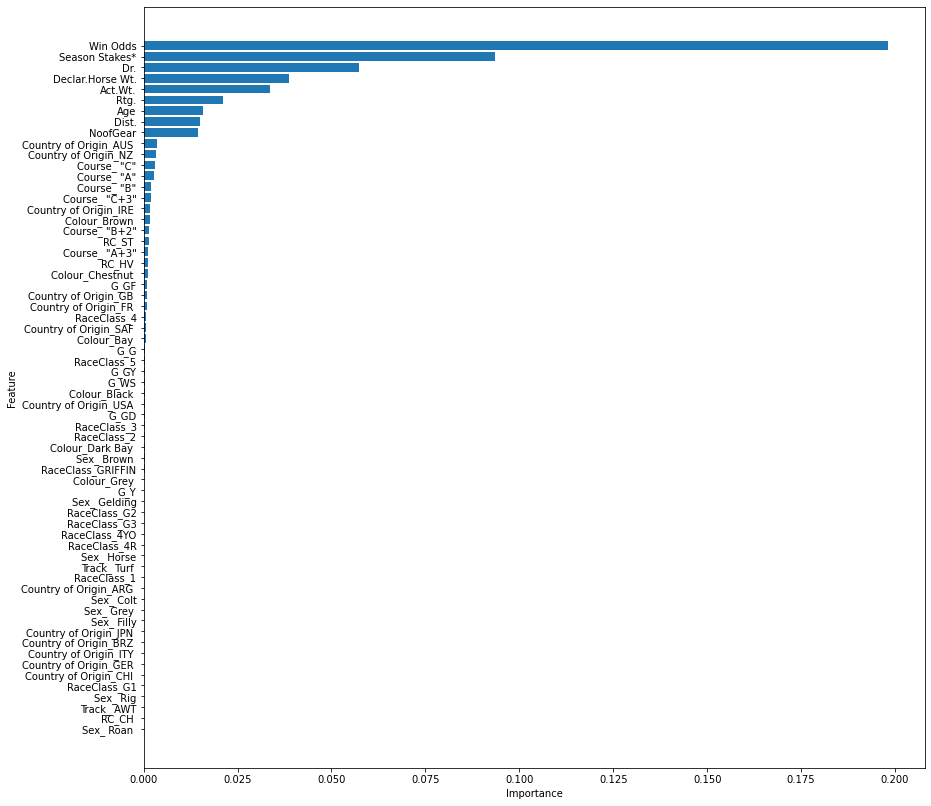

In [ ]:
# importance in decreasing order
imp_ord = np.argsort(perm.feature_importances_)

plt.figure(figsize=(14,14))
yaxis = np.arange(len(perm.feature_importances_))*1
plt.barh(y = yaxis,width = perm.feature_importances_[imp_ord])
plt.yticks(yaxis,feature[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

In [ ]:
importance_table=pd.DataFrame({'features':feature[imp_ord],'importance':perm.feature_importances_[imp_ord]})
print(importance_table.to_string())

                  features  importance
0               Sex_ Roan     0.000000
1                   RC_CH     0.000000
2               Track_ AWT    0.000000
3                 Sex_ Rig    0.000000
4             RaceClass_G1    0.000000
5   Country of Origin_CHI     0.000000
6   Country of Origin_GER     0.000000
7   Country of Origin_ITY     0.000000
8   Country of Origin_BRZ     0.000000
9   Country of Origin_JPN     0.000000
10              Sex_ Filly    0.000000
11              Sex_ Grey     0.000000
12               Sex_ Colt    0.000085
13  Country of Origin_ARG     0.000085
14             RaceClass_1    0.000085
15            Track_ Turf     0.000085
16              Sex_ Horse    0.000085
17            RaceClass_4R    0.000085
18           RaceClass_4YO    0.000085
19            RaceClass_G3    0.000085
20            RaceClass_G2    0.000085
21            Sex_ Gelding    0.000170
22                     G_Y    0.000170
23            Colour_Grey     0.000170
24       RaceClass_GRIFFI

In [ ]:
#we select the features with importance > 0.01
selected=importance_table[importance_table['importance']>0.01]["features"]
selected

55            NoofGear
56               Dist.
57                 Age
58                Rtg.
59             Act.Wt.
60    Declar.Horse Wt.
61                 Dr.
62      Season Stakes*
63            Win Odds
Name: features, dtype: object

In [ ]:
df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
x_train = df_train.iloc[:,6:].values
sx_train = df_train[selected].values
y3_train = df_train["top3"]
y1_train = df_train["top1"]

pos_test = df_test["Pla."]
x_test = df_test.iloc[:,6:].values
y3_test = df_test["top3"]
y1_test = df_test["top1"]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(sx_train, y3_train)
y3_pred=rf_clf.predict(sx_test)
print('Accuracy for top 3 with selectd features >0.01:', accuracy_score(y3_test, y3_pred).round(4))

Accuracy for top 3 with selectd features >0.01: 0.748


In [ ]:
Outcome=pd.DataFrame({'position':df_test["Pla."],'y3_pred':y3_pred,'y3_test':y3_test,'top 3 Win Odds':df_test['top3Winodd'],})
Outcome['top 3 net'] = np.where(Outcome['y3_pred']==1,np.where(Outcome['y3_test']==1,(abs(Outcome['top 3 Win Odds']-1)*10),-10), 0)
Outcome

,position,y3_pred,y3_test,top 3 Win Odds,top 3 net
9317,1,1,1,12.5,115.0
6792,9,0,0,0.0,0.0
12640,3,0,1,16.0,0.0
13096,4,1,0,0.0,-10.0
2911,3,0,1,19.5,0.0
...,...,...,...,...,...
13027,3,0,1,0.0,0.0
14139,6,1,0,0.0,-10.0
8503,6,0,0,0.0,0.0
341,11,0,0,0.0,0.0


In [ ]:
Outcome.sum()

position          18766.0
y3_pred             550.0
y3_test             824.0
top 3 Win Odds    23218.4
top 3 net         38743.0
dtype: float64

### 3. Model consider variable importance and interaction effect: classifer on 'top3'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

selected_features=[]
accuracy=[]

df_train, df_test = train_test_split(fdf,test_size=0.2)
y_train = df_train["top3"]
y_test = df_test["top3"]

for i in range (-1, -65, -1):
  print("Adding", feature[imp_ord][i])
  selected_features.append(feature[imp_ord][i])
  x_train=df_train[selected_features].values
  x_test=df_test[selected_features].values
  rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
  rf_clf.fit(x_train, y_train)
  accuracy.append(accuracy_score(y_test, rf_clf.predict(x_test)).round(4))
  print('selected :',len(selected_features),'Accuracy : ', accuracy_score(y_test, rf_clf.predict(x_test)).round(4))
  print("="*20)

In [ ]:
list=[]
for i in range (1, 65):
  list.append(i)
Accuracy_table=pd.DataFrame({'number of features':list,'RF accuracy':accuracy})

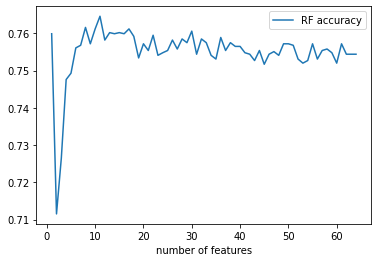

In [ ]:
Accuracy_table.plot(x ='number of features', y='RF accuracy')

Hence, we selected the top 11 features for random forest model 

In [ ]:
opt_feature=selected_features[0:11]
#opt_feature=['Win Odds','Season Stakes*','Dr.','Act.Wt.','Declar.Horse Wt.','Rtg.','NoofGear','Age','Dist.','Country of Origin_AUS ','Course_ "A"']

df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
x_train = df_train.iloc[:,7:].values
sx_train = df_train[opt_feature].values
y3_train = df_train["top3"]
y1_train = df_train["top1"]

pos_test = df_test["Pla."]
x_test = df_test.iloc[:,7:].values
sx_test = df_test[opt_feature].values
y3_test = df_test["top3"]
y1_test = df_test["top1"]

feature=df_train.columns[7:].values

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(sx_train, y3_train)
y3_pred=rf_clf.predict(sx_test)
print('Accuracy for top 3 with 11 selectd features:', accuracy_score(y3_test, y3_pred).round(4))

Accuracy for top 3 with 11 selectd features: 0.7568


In [ ]:
Outcome=pd.DataFrame({'position':df_test["Pla."],'y3_pred':y3_pred,'y3_test':y3_test,'top 3 Win Odds':df_test['top3Winodd']})
Outcome['top 3 net'] = np.where(Outcome['y3_pred']==1,np.where(Outcome['y3_test']==1,(abs(Outcome['top 3 Win Odds']-1)*10),-10), 0)
Outcome

,position,y3_pred,y3_test,top 3 Win Odds,top 3 net
3126,14,0,0,0.0,0.0
1230,3,0,1,56.5,0.0
12491,6,0,0,0.0,0.0
9947,12,0,0,0.0,0.0
8518,1,0,1,37.0,0.0
...,...,...,...,...,...
14274,1,0,1,67.0,0.0
8366,6,0,0,0.0,0.0
730,5,0,0,0.0,0.0
12619,2,0,1,25.0,0.0


In [ ]:
Outcome[(Outcome["y3_pred"]==1) & (Outcome["y3_test"]==1)]

In [ ]:
Outcome[(Outcome["y3_pred"]==0) & (Outcome["y3_test"]==0)]

,position,y3_pred,y3_test,top 3 Win Odds,top 3 net
3126,14,0,0,0.0,0.0
12491,6,0,0,0.0,0.0
9947,12,0,0,0.0,0.0
5132,6,0,0,0.0,0.0
13184,11,0,0,0.0,0.0
...,...,...,...,...,...
14531,4,0,0,0.0,0.0
5225,13,0,0,0.0,0.0
8366,6,0,0,0.0,0.0
730,5,0,0,0.0,0.0


In [ ]:
Outcome.sum()

position          18815.0
y3_pred             542.0
y3_test             828.0
top 3 Win Odds    21485.0
top 3 net         38174.0
dtype: float64

In [ ]:
selected=selected_features[0:13]
df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
sx_train = df_train[selected].values
y_train = df_train["top3"]

pos_test = df_test["Pla."]
sx_test = df_test[selected].values
y_test = df_test["top3"]

### 4. Model Consider hyperparameter tuning on 'top3'

In [ ]:
print('Parameters currently in use:\n')
print(rf_clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}

clf = GridSearchCV(rf_model, model_params, cv=5)

model = clf.fit(sx_train, y_train)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [ ]:
print('Selected 11 features accuracy:', accuracy_score(y3_test, model.predict(sx_test)).round(4))

Selected 11 features accuracy: 0.7629


In [ ]:
Outcome=pd.DataFrame({'y_pred':model.predict(sx_test),'y_test':y3_test,'Win Odds':df_test['top3Winodd'],'position':df_test["Pla."]})
Outcome['net'] = np.where(Outcome['y_pred']==1,np.where(Outcome['y_test']==1,(abs(Outcome['Win Odds']-1)*10),-10), 0)
print(Outcome)
print(Outcome.sum())

       y_pred  y_test  Win Odds  position    net
5569        1       1      15.5         2  145.0
8558        0       0       0.0         8    0.0
12354       0       1       0.0         2    0.0
240         0       0       0.0         5    0.0
3795        1       1      22.5         3  215.0
...       ...     ...       ...       ...    ...
9392        0       0       0.0        12    0.0
3221        0       0       0.0         4    0.0
2146        0       0       0.0         4    0.0
944         0       1      16.5         3    0.0
11857       0       0       0.0         7    0.0

[2936 rows x 5 columns]
y_pred        487.0
y_test        805.0
Win Odds    23097.4
position    18848.0
net         36454.0
dtype: float64


When the y_pred =1, we will pay 10HKD for betting, if y_test =1, that means our prediction is correct, the horse is in the top3 places, we will get 'Win Odds'*10, which mean we will have (winodd-1)*10 return.
if we pay 10HKD and the horse does not win, we lose 10HKD so the 'net'column = -10
If the y_pred =0, our model predict the horse can not win in the 'place' betting system and hence we will not bet on it. The corresponding 'net' column will be 0

### Model consider variable importance: classifer on 'top1'



In [ ]:
#pip install eli5import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(x_train, y1_train)
perm = PermutationImportance(rf_clf).fit(x_train, y1_train)
eli5.show_weights(perm, feature_names=feature)

Weight,Feature
0.0782 ± 0.0035,Win Odds
0.0534 ± 0.0035,Season Stakes*
0.0401 ± 0.0016,Dr.
0.0336 ± 0.0013,Declar.Horse Wt.
0.0324 ± 0.0018,Act.Wt.
0.0240 ± 0.0018,Rtg.
0.0177 ± 0.0015,Age
0.0166 ± 0.0006,NoofGear
0.0148 ± 0.0007,Dist.
0.0074 ± 0.0012,Country of Origin_AUS


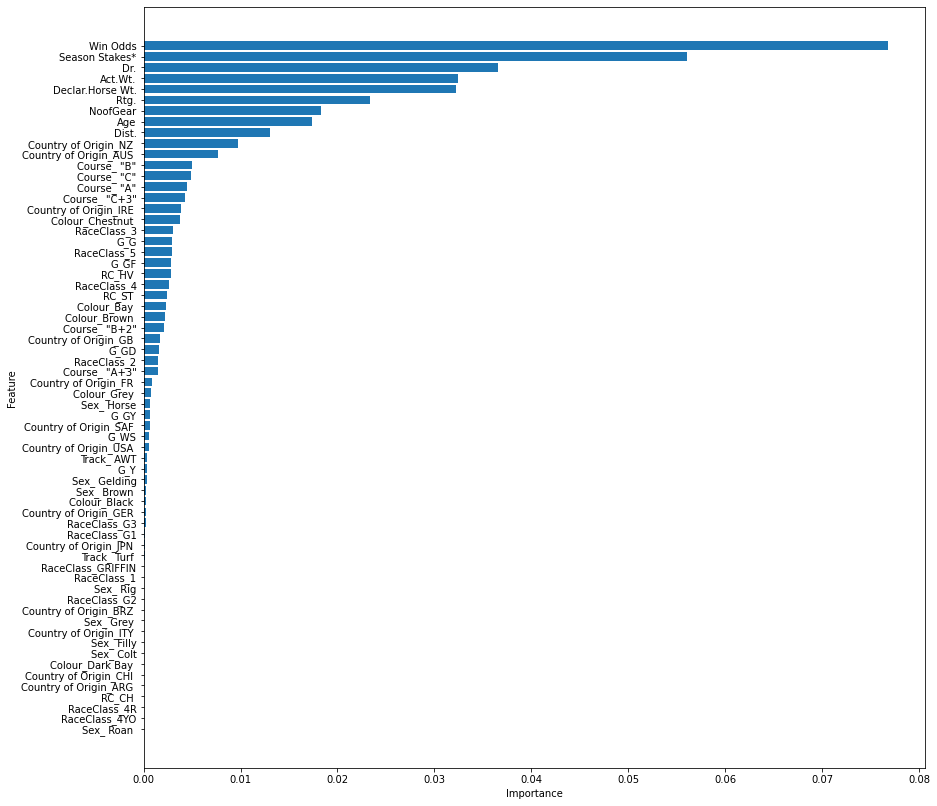

In [ ]:
# importance in decreasing order
imp_ord = np.argsort(perm.feature_importances_)

plt.figure(figsize=(14,14))
yaxis = np.arange(len(perm.feature_importances_))*1
plt.barh(y = yaxis,width = perm.feature_importances_[imp_ord])
plt.yticks(yaxis,feature[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

In [ ]:
top1_importance_table=pd.DataFrame({'features':feature[imp_ord],'importance':perm.feature_importances_[imp_ord]})
print(top1_importance_table.to_string())

                  features  importance
0               Sex_ Roan     0.000085
1                   RC_CH     0.000000
2               Track_ AWT    0.000545
3                 Sex_ Rig    0.000085
4             RaceClass_G1    0.000256
5   Country of Origin_CHI     0.000085
6   Country of Origin_GER     0.000392
7   Country of Origin_ITY     0.000000
8   Country of Origin_BRZ     0.000170
9   Country of Origin_JPN     0.000085
10              Sex_ Filly    0.000000
11              Sex_ Grey     0.000000
12               Sex_ Colt    0.000000
13  Country of Origin_ARG     0.000000
14             RaceClass_1    0.000256
15            Track_ Turf     0.000937
16              Sex_ Horse    0.000426
17            RaceClass_4R    0.000000
18           RaceClass_4YO    0.000000
19            RaceClass_G3    0.000256
20            RaceClass_G2    0.000170
21            Sex_ Gelding    0.000238
22                     G_Y    0.000426
23            Colour_Grey     0.000971
24       RaceClass_GRIFFI

In [ ]:
#we select the features with importance > 0.01
selected=["NoofGear", "Dist.","Age","Rtg.", "Act.Wt.","Declar.Horse Wt.","Dr.", "Season Stakes*", "Win Odds"]
#selected=importance_table[importance_table['importance']>0.01]["features"]
sx_train = df_train[selected].values
sx_test = df_test[selected].values

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(sx_train, y1_train)
y1_pred=rf_clf.predict(sx_test)
print('Accuracy:', accuracy_score(y1_test, y1_pred).round(4))

Accuracy: 0.9026


In [ ]:
Outcome=pd.DataFrame({'y_pred':y1_pred,'y1_test':y1_test,'Win Odds':df_test['Win Odds'],'position':df_test["Pla."]})
Outcome['net'] = np.where(Outcome['y_pred']==1,np.where(Outcome['y1_test']==1,(Outcome['Win Odds']-1)*10,-10), 0)
Outcome

,y_pred,y1_test,Win Odds,position,net
7555,0,0,26.0,4,0.0
1505,0,0,5.5,8,0.0
8722,0,0,90.0,10,0.0
11164,0,0,9.4,3,0.0
8054,0,0,9.8,5,0.0
...,...,...,...,...,...
11919,0,0,43.0,6,0.0
1358,0,0,9.5,8,0.0
6611,0,1,9.0,1,0.0
12219,0,0,2.6,4,0.0


In [ ]:
Outcome.sum()

y_pred          52.0
y1_test        286.0
Win Odds    118469.2
position     18539.0
net              6.0
dtype: float64

### Model consider variable importance and interaction effect: classifer on 'top1'

In [ ]:
selected_features=[]
accuracy=[]

df_train, df_test = train_test_split(fdf,test_size=0.2)
y_train = df_train["top1"]
y_test = df_test["top1"]

for i in range (-1, -65, -1):
  print("Adding", feature[imp_ord][i])
  selected_features.append(feature[imp_ord][i])
  x_train=df_train[selected_features].values
  x_test=df_test[selected_features].values
  rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
  rf_clf.fit(x_train, y_train)
  accuracy.append(accuracy_score(y_test, rf_clf.predict(x_test)).round(4))
  print('selected :',len(selected_features),'Accuracy : ', accuracy_score(y_test, rf_clf.predict(x_test)).round(4))
  print("="*20)

Adding Win Odds
selected : 1 Accuracy :  0.9084
Adding Season Stakes*
selected : 2 Accuracy :  0.8873
Adding Dr.
selected : 3 Accuracy :  0.8917
Adding Act.Wt.
selected : 4 Accuracy :  0.9022
Adding Declar.Horse Wt.
selected : 5 Accuracy :  0.907
Adding Rtg.
selected : 6 Accuracy :  0.9067
Adding NoofGear
selected : 7 Accuracy :  0.9067
Adding Age
selected : 8 Accuracy :  0.9067
Adding Dist.
selected : 9 Accuracy :  0.9084
Adding Country of Origin_NZ 
selected : 10 Accuracy :  0.9077
Adding Country of Origin_AUS 
selected : 11 Accuracy :  0.9067
Adding Course_ "B"
selected : 12 Accuracy :  0.9074
Adding Course_ "C"
selected : 13 Accuracy :  0.9077
Adding Course_ "A"
selected : 14 Accuracy :  0.9091
Adding Course_ "C+3"
selected : 15 Accuracy :  0.9084
Adding Country of Origin_IRE 
selected : 16 Accuracy :  0.908
Adding Colour_Chestnut 
selected : 17 Accuracy :  0.9063
Adding RaceClass_3
selected : 18 Accuracy :  0.9057
Adding G_G
selected : 19 Accuracy :  0.9063
Adding RaceClass_5
sele

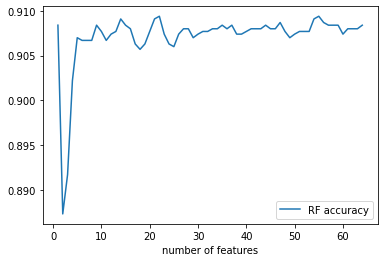

In [ ]:
list=[]
for i in range (1, 65):
  list.append(i)
Accuracy_table=pd.DataFrame({'number of features':list,'RF accuracy':accuracy})
Accuracy_table.plot(x ='number of features', y='RF accuracy')

In [ ]:
opt_feature=selected_features[0:14]
opt_feature

['Win Odds',
 'Season Stakes*',
 'Dr.',
 'Act.Wt.',
 'Declar.Horse Wt.',
 'Rtg.',
 'NoofGear',
 'Age',
 'Dist.',
 'Country of Origin_NZ ',
 'Country of Origin_AUS ',
 'Course_ "B"',
 'Course_ "C"',
 'Course_ "A"']

The maximum accuracy is attained when 14 variables are included. The accuracy  = 0.9091

In [ ]:
# calculate the award based on the existing model

opt_selected=['Win Odds','Season Stakes*','Dr.','Act.Wt.','Declar.Horse Wt.','Rtg.','NoofGear',
 'Age','Dist.','Country of Origin_NZ ','Country of Origin_AUS ','Course_ "B"','Course_ "C"','Course_ "A"']

df_train, df_test = train_test_split(fdf,test_size=0.2)

pos_train = df_train["Pla."]
sx_train = df_train[opt_selected].values
y1_train = df_train["top1"]

pos_test = df_test["Pla."]
sx_test = df_test[opt_selected].values
y1_test = df_test["top1"]

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rf_clf.fit(sx_train, y1_train)
y1_pred=rf_clf.predict(sx_test)
print('Accuracy:', accuracy_score(y1_test, y1_pred).round(4))

Accuracy: 0.9094


In [ ]:
Outcome=pd.DataFrame({'y_pred':y1_pred,'y1_test':y1_test,'Win Odds':df_test['Win Odds'],'position':df_test["Pla."]})
Outcome['net'] = np.where(Outcome['y_pred']==1,np.where(Outcome['y1_test']==1,(Outcome['Win Odds']-1)*10,-10), 0)
Outcome

,y_pred,y1_test,Win Odds,position,net
9765,0,0,8.2,2,0.0
14309,0,0,9.5,7,0.0
13831,0,0,7.7,7,0.0
13482,0,0,3.4,2,0.0
1843,0,1,15.0,1,0.0
...,...,...,...,...,...
7161,0,1,3.0,1,0.0
8083,0,0,27.0,10,0.0
11749,0,0,166.0,10,0.0
10420,0,0,9.2,3,0.0


In [ ]:
Outcome.sum()

y_pred          38.0
y1_test        266.0
Win Odds    118476.5
position     18746.0
net            -32.0
dtype: float64

### Model consider hyperparameter tuning on 'top1'

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}

clf = GridSearchCV(rf_model, model_params, cv=5)

model = clf.fit(sx_train, y1_train)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [ ]:
print('Selected 14 features accuracy:', accuracy_score(y1_test, model.predict(sx_test)).round(4))

Selected 14 features accuracy: 0.9029


In [ ]:
Outcome=pd.DataFrame({'y_pred':model.predict(sx_test),'y_test':y1_test,'Win Odds':df_test['Win Odds'],'position':df_test["Pla."]})
Outcome['net'] = np.where(Outcome['y_pred']==1,np.where(Outcome['y_test']==1,(abs(Outcome['Win Odds']-1)*10),-10), 0)
print(Outcome)
print(Outcome.sum())

       y_pred  y_test  Win Odds  position  net
7555        0       0      26.0         4  0.0
1505        0       0       5.5         8  0.0
8722        0       0      90.0        10  0.0
11164       0       0       9.4         3  0.0
8054        0       0       9.8         5  0.0
...       ...     ...       ...       ...  ...
11919       0       0      43.0         6  0.0
1358        0       0       9.5         8  0.0
6611        0       1       9.0         1  0.0
12219       0       0       2.6         4  0.0
11555       0       0      26.0         8  0.0

[2936 rows x 5 columns]
y_pred          33.0
y_test         286.0
Win Odds    118469.2
position     18539.0
net              8.0
dtype: float64


## Neural Network (Approach: Place)

### Hyperparameter tuning

In [22]:
# Load the dataset
from sklearn.neural_network import MLPClassifier
full_data = pd.read_csv("drive/MyDrive/COMP3359 Project/full_data_update.csv")

# split the features and expected result
y_df = full_data[["top3"]]
y_df["class"] = y_df["top3"]
x_df = full_data.drop(["horse", "N_RaceIndex", "Pla.", "Finish Time", "top3", "top1"], axis = 1)
y_df.drop(["top3"], axis=1, inplace=True)

# split the train set and test set
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size = 0.2)
train_outcome = train_x[["top3Winodd"]]
test_outcome = test_x[["top3Winodd"]]
train_x.drop(["top3Winodd"], axis=1, inplace=True)
test_x.drop(["top3Winodd"], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Hyperparameter tuning (Do not run this cell)
scores = []
for i in range(1, 5):
    model = MLPClassifier(hidden_layer_sizes=i*100, batch_size=36).fit(train_x, train_y)
    scores.append(model.score(test_x, test_y))

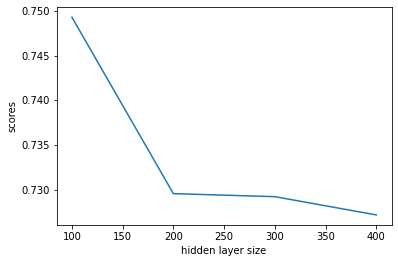

In [ ]:
# Hyperparameter tuning (Do not run this cell)
import matplotlib.pyplot as plt
plt.plot([100, 200, 300, 400], scores)
plt.ylabel("scores")
plt.xlabel("hidden layer size")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

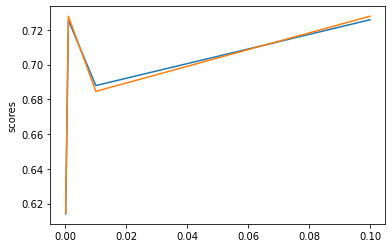

In [ ]:
# Hyperparameter tuning (Do not run this cell)
scores = []
for i in [0.0001, 0.001, 0.01, 0.1]:
    model = MLPClassifier(hidden_layer_sizes=100, learning_rate_init=i, batch_size=36).fit(train_x, train_y)
    scores.append([model.score(train_x, train_y), model.score(test_x, test_y)])

import matplotlib.pyplot as plt
plt.plot([0.0001, 0.001, 0.01, 0.1], scores)
plt.ylabel("scores")
plt.annotate
plt.show()

In [ ]:
# Hyperparameter tuning (Do not run this cell)
from sklearn.model_selection import GridSearchCV

selected=['Win Odds','Season Stakes*','Dr.','Declar.Horse Wt.','Act.Wt.','Rtg.','Age','NoofGear','Dist.','Country of Origin_AUS ','Country of Origin_NZ ','Country of Origin_IRE ']
train_x_2 = train_x[selected]
test_x_2 = test_x[selected]

parameter_space = {
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

model = MLPClassifier(hidden_layer_sizes=200, solver="sgd", activation="tanh", alpha=0.0001, max_iter=1)

clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)
clf.fit(train_x_2, train_y)
print(clf.best_params_)

{'activation': 'tanh', 'alpha': 0.0001, 'learning_rate': 'constant', 'solver': 'sgd'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# NN Model Result (Predicting Place (Top 3))
# Do not run this cell
model = MLPClassifier(hidden_layer_sizes=100, solver="sgd", activation="tanh", alpha=0.0001, early_stopping=True).fit(train_x, train_y)
predict = model.predict(test_x)
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7258325525934759
0.7278610354223434


In [ ]:
# NN Model Result (Predicting Place (Top 1))
# Do not run this cell
predict = model.predict_proba(test_x)
temp = pd.DataFrame(predict, columns=["0", "1"])

print(model.score(test_x, test_y))
temp.describe()

0.9053133514986376


,0,1
count,2936.000000,2936.000000
mean,0.892446,0.107554
std,0.022164,0.022164
min,0.830381,0.034561
25%,0.883954,0.116046
50%,0.883954,0.116046
75%,0.883954,0.116046
max,0.965439,0.169619


### Model

In [23]:
# Select the important features only
selected=['Win Odds','Season Stakes*','Dr.','Declar.Horse Wt.','Act.Wt.','Rtg.','Age','NoofGear','Dist.','Country of Origin_AUS ','Country of Origin_NZ ','Country of Origin_IRE ']
train_x_2 = train_x[selected]
test_x_2 = test_x[selected]

In [24]:
# NN Model (Predicting Place(Top 3))
model = MLPClassifier(hidden_layer_sizes=100, solver="sgd", activation="tanh", alpha=0.0001, early_stopping=True).fit(train_x_2, train_y)
predict = model.predict(test_x_2)
print("Example result: Class " + str(predict[0]))
print("Real value : Class " + str(test_y.iloc[0]["class"]))
print(model.score(train_x_2, train_y))
print(model.score(test_x_2, test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Example result: Class 0
Real value : Class 1
0.727195298526531
0.7224114441416893


In [ ]:
# Build a new DataFrame to count net gain/loss 
outcome = pd.DataFrame({'pred':predict,'Real':test_y["class"],'Win Odds':test_outcome["top3Winodd"]})
outcome

,pred,Real,Win Odds
2832,0,0,NaN
9035,0,0,NaN
10928,0,0,NaN
10294,0,0,NaN
5246,0,0,NaN
...,...,...,...
7692,0,0,NaN
5267,0,1,42.5
2559,0,0,NaN
12538,0,1,21.5


In [ ]:
# Count the net gain/loss
outcome["Win Odds"].fillna(0.0, inplace=True)
outcome['net'] = np.where(outcome['pred']==1, np.where(outcome['Real']==1, abs((outcome["Win Odds"] - 1)*10), -10), 0)
outcome

,pred,Real,Win Odds,net
2832,0,0,1.0,0.0
9035,0,0,1.0,0.0
10928,0,0,1.0,0.0
10294,0,0,1.0,0.0
5246,0,0,1.0,0.0
...,...,...,...,...
7692,0,0,1.0,0.0
5267,0,1,42.5,0.0
2559,0,0,1.0,0.0
12538,0,1,21.5,0.0


In [ ]:
outcome["net"].sum()

0.0

In [ ]:
sum(outcome["pred"]==1)
# In this cell, we found that the model is not learning

0

## Neural Network (Approach: Time)

### Prepare Data

In [25]:
# Selecting the features for predicting finish time
import random

# read the data set
data_df = pd.read_csv("drive/MyDrive/COMP3359 Project/full_data_update.csv")

# Normalize Dist. and season stakes
data_df["Season Stakes*"] = data_df["Season Stakes*"] / 100000
data_df["Dist."] = (data_df["Dist."] - 1000) / 1400

# Drop the uneless columns and columns which may interfer the model
data_df.drop(["Pla.", "horse", "N_RaceIndex", "top3", "top1", "top3Winodd"], axis=1, inplace=True)
for col in data_df.select_dtypes(include=['object']).columns:
    data_df[col] = data_df[col].astype('category')
for col in data_df.select_dtypes(include=['category']).columns:
    data_df[col] = data_df[col].cat.codes

RAND_SEED = 3359
TRAIN_SIZE = 0.8

all_index = list(range(len(data_df)))

random.seed(RAND_SEED)
random.shuffle(all_index)

train_size = int(len(data_df) * TRAIN_SIZE)
train_idx = all_index[:train_size]
test_idx = all_index[train_size:]

# Split the train and test set
x_data_df, y_data_df = data_df.drop(["Finish Time"], axis=1), data_df["Finish Time"]
train_x, test_x = x_data_df.iloc[train_idx], x_data_df.iloc[test_idx]
train_y, test_y = y_data_df.iloc[train_idx], y_data_df.iloc[test_idx]

train_x = train_x.reset_index()
test_x = test_x.reset_index()
train_y = train_y.reset_index()
test_y = test_y.reset_index()

train_y.drop(["index"], axis=1, inplace=True)
test_y.drop(["index"], axis=1, inplace=True)
train_x.drop(["index"], axis=1, inplace=True)
test_x.drop(["index"], axis=1, inplace=True)

# select the important features 
selected=['Win Odds','Season Stakes*','Dr.','Declar.Horse Wt.','Act.Wt.','Rtg.','Age','NoofGear','Dist.','Country of Origin_AUS ','Country of Origin_NZ ','Country of Origin_IRE ']
train_x_2 = train_x[selected]
test_x_2 = test_x[selected]

In [ ]:
test_x

,Dist.,Dr.,Rtg.,Win Odds,Act.Wt.,Declar.Horse Wt.,NoofGear,Season Stakes*,Age,G_G,G_GD,G_GF,G_GY,G_WS,G_Y,RaceClass_1,RaceClass_2,RaceClass_3,RaceClass_4,RaceClass_4R,RaceClass_4YO,RaceClass_5,RaceClass_G1,RaceClass_G2,RaceClass_G3,RaceClass_GRIFFIN,RC_CH,RC_HV,RC_ST,Track_ AWT,Track_ Turf,"Course_ ""A""","Course_ ""A+3""","Course_ ""B""","Course_ ""B+2""","Course_ ""C""","Course_ ""C+3""",Country of Origin_ARG,Country of Origin_AUS,Country of Origin_BRZ,Country of Origin_CHI,Country of Origin_FR,Country of Origin_GB,Country of Origin_GER,Country of Origin_IRE,Country of Origin_ITY,Country of Origin_JPN,Country of Origin_NZ,Country of Origin_SAF,Country of Origin_USA,Colour_Bay,Colour_Black,Colour_Brown,Colour_Chestnut,Colour_Dark Bay,Colour_Grey,Sex_ Brown,Sex_ Colt,Sex_ Filly,Sex_ Gelding,Sex_ Grey,Sex_ Horse,Sex_ Rig,Sex_ Roan
0,0.142857,12,71.0,37.0,124,1037.0,1,9.2250,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.285714,6,58.0,2.5,133,1080.0,2,14.7000,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0.000000,13,65.0,14.0,118,1238.0,1,8.6900,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0.285714,4,75.0,18.0,128,1075.0,3,17.8500,7,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.285714,5,78.0,3.4,131,1101.0,1,9.0950,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2931,0.285714,2,54.0,7.9,124,1068.0,0,0.2625,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2932,0.285714,1,79.0,3.3,132,1210.0,0,1.7250,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2933,0.142857,1,46.0,13.0,116,1105.0,0,9.2000,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2934,0.285714,11,90.0,8.2,125,1168.0,8,0.0000,7,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


### Experiment & Parameters Tuning

In [26]:
# Import the libs for this section
from sklearn.neural_network import MLPRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


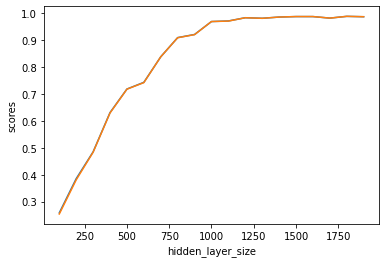

In [ ]:
# Experiment(Don't Run this cell)
scores = []
index = []
for i in range(1, 20):
    model = MLPRegressor(hidden_layer_sizes=i*100, random_state=RAND_SEED, batch_size="auto").fit(train_x_2, train_y)
    scores.append([model.score(train_x_2, train_y), model.score(test_x_2, test_y)])
    index.append(i*100)

import matplotlib.pyplot as plt
plt.plot(index, scores)
plt.ylabel("scores")
plt.xlabel("hidden_layer_size")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

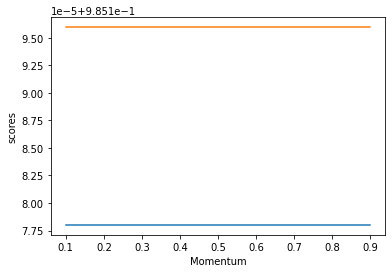

In [ ]:
# Experiment(Don't Run this cell)
scores = []
index = []
for i in range(1, 10):
    model = MLPRegressor(hidden_layer_sizes=1250, random_state=RAND_SEED, batch_size="auto", momentum=i*0.1).fit(train_x_2, train_y)
    scores.append([model.score(train_x_2, train_y), model.score(test_x_2, test_y)])
    index.append(i*0.1)

import matplotlib.pyplot as plt
plt.plot(index, scores)
plt.ylabel("scores")
plt.xlabel("Momentum")
plt.show()

In [ ]:
# Hyperparameters tuning (Don't Run this cell)
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

model = MLPRegressor(hidden_layer_sizes=1200)
clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)
clf.fit(train_x_2, train_y)
print(clf.best_params_)

NameError: ignored

In [27]:
# NN Model (Predicting Time)
model = MLPRegressor(hidden_layer_sizes=1250, batch_size="auto", solver="adam", alpha=0.0001).fit(train_x_2, train_y)
print(model.score(train_x_2, train_y))
print(model.score(test_x_2, test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9835107430726624
0.9834855347179524


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


From the table above, we can see that over 70% of the dataset are actually 